# Fit and export the sleep staging classifier

In [1]:
import os
import glob
import shap
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from lightgbm import LGBMClassifier
sns.set(font_scale=1.25)

# Define path
parent_dir = os.getcwd()
wdir = parent_dir + '/output/features/'
wdir_demo = parent_dir + '/output/demo/'
outdir = parent_dir + "/output/classifiers/"
assert os.path.isdir(wdir)
assert os.path.isdir(wdir_demo)
assert os.path.isdir(outdir)

## Load the feature files

### Method 1: Loop across all datasets

In [2]:
# feat_files = glob.glob(wdir + "features_nsrr*.parquet")

# df = []
# for f in tqdm(feat_files):
#     # Load current file
#     print(f)
#     tmp = pd.read_parquet(f)
#     # Convert dtypes and downcast float
#     tmp['age'] = tmp['age'].astype('int8')
#     tmp['male'] = tmp['male'].astype('category')
#     cols_float = tmp.select_dtypes(np.float64).columns.tolist()
#     tmp[cols_float] = tmp[cols_float].astype(np.float32)
#     # Append to main dataframe and delete tmp
#     df.append(tmp)
#     del tmp
    
# df = pd.concat(df)
# print("There are %i unique nights" % df.index.get_level_values(0).nunique())
# df.head().round(2)

# # Save the concatenated file
# df.to_parquet(wdir + "features_all.parquet")

### Method 2: Concatenated file

Need to run Method 1 at least once to enable this.

In [3]:
# Or we can simply use a pre-saved concatenated file
df = pd.read_parquet(wdir + "features_all.parquet")
print("There are %i unique nights" % df.index.get_level_values(0).nunique())
df.head().round(2)

There are 3163 unique nights


age   eeg_abspow  eeg_abspow_c7min_norm  eeg_abspow_p2min_norm  \
subj   epoch                                                                   
300001 0        8   757.359985                  -0.02                  -0.02   
       1        8   870.109985                  -0.01                  -0.01   
       2        8  1116.589966                   0.00                   0.02   
       3        8   276.269989                   0.02                  -0.02   
       4        8    71.839996                   0.05                  -0.07   

              eeg_alpha  eeg_alpha_c7min_norm  eeg_alpha_p2min_norm  eeg_at  \
subj   epoch                                                                  
300001 0           0.01                  0.54                 -0.18    0.24   
       1           0.02                  0.56                 -0.15    0.33   
       2           0.01                  0.59                 -0.21    0.21   
       3           0.09                  0.62                  0.35    0.30   
       4           0.14                  0.58                  1.23    0.56   

              eeg_at_c7min_norm  eeg_at_p2min_norm  ...  eog_std_c7min_norm  \
subj   epoch                                        ...                       
300001 0                   0.17               0.07  ...                0.48   
       1                   0.16               0.16  ...                0.52   
       2                   0.15               0.10  ...                0.58   
       3                   0.14               0.12  ...                0.64   
       4                   0.12               0.29  ...                0.68   

              eog_std_p2min_norm  eog_theta  eog_theta_c7min_norm  \
subj   epoch                                                        
300001 0                    0.50       0.04                  0.19   
       1                    0.18       0.05                  0.21   
       2                    0.29       0.03                  0.24   
       3                    0.44       0.31                  0.29   
       4                    0.30       0.22                  0.24   

              eog_theta_p2min_norm  male  time_hour  time_norm  stage  dataset  
subj   epoch                                                                    
300001 0                     -0.44     0       0.00        0.0      W     chat  
       1                     -0.38     0       0.01        0.0      W     chat  
       2                     -0.44     0       0.02        0.0      W     chat  
       3                      0.29     0       0.02        0.0      W     chat  
       4                      0.77     0       0.03        0.0      W     chat  

[5 rows x 153 columns]

In [4]:
# Check units of datasets
df.groupby('dataset')['eeg_iqr'].describe().round(2)

,count,mean,std,min,25%,50%,75%,max
dataset,,,,,,,,
ccshs,554444.0,28.01,34.66,0.0,14.27,19.63,31.11,990.07
cfs,694927.0,25.39,37.19,0.0,12.13,17.33,27.39,1010.59
chat,429988.0,54.74,123.99,0.0,26.00,36.29,58.85,12212.25
homepap,76069.0,13.90,30.48,0.0,5.45,9.08,14.43,2693.20
mesa,726077.0,73.61,431.35,0.0,13.74,18.63,29.05,9864.67
mros,727933.0,18.70,16.93,0.0,10.95,14.74,21.22,494.84
shhs1,597769.0,24.86,35.20,0.0,12.47,16.18,22.11,255.55


### Add demographics (race, BMI)

In [5]:
df_demo = pd.read_csv(wdir_demo + "demo_nsrr_all.csv")
# Remove columns that are already present in `df`
df_demo.drop(columns=['male', 'age'], inplace=True)
df_demo

,dataset,subj,bmi,ahi,ethnicity,set
0,CCSHS,1800001,19.089716,0.244898,caucasian,training
1,CCSHS,1800005,29.338584,0.239521,caucasian,testing
2,CCSHS,1800007,35.897564,1.846154,african,training
3,CCSHS,1800013,21.176986,0.113636,caucasian,training
4,CCSHS,1800014,33.587853,1.901408,african,training
...,...,...,...,...,...,...
3876,SHHS,205792,37.393649,25.096154,caucasian,training
3877,SHHS,205794,22.313278,3.262840,caucasian,training
3878,SHHS,205799,32.414213,3.287671,caucasian,training
3879,SHHS,205800,25.693134,53.535660,caucasian,training


In [6]:
grp_subj = df.groupby(level=0, as_index=True)[['age', 'male', 'dataset']].first()
grp_subj.reset_index(inplace=True)
# Preprocessing before merge
grp_subj['subj'] = grp_subj['subj'].astype(str)
grp_subj['dataset'] = grp_subj['dataset'].str.upper()
grp_subj['dataset'] = grp_subj['dataset'].replace({'SHHS1': 'SHHS'})
# Left merge to keep only training set
grp_subj = grp_subj.merge(df_demo, how="left")
grp_subj = grp_subj.sort_values(by=['dataset', 'subj']).reset_index(drop=True)
grp_subj

,subj,age,male,dataset,bmi,ahi,ethnicity,set
0,1800001,17,0,CCSHS,19.089716,0.244898,caucasian,training
1,1800007,18,1,CCSHS,35.897564,1.846154,african,training
2,1800013,18,1,CCSHS,21.176986,0.113636,caucasian,training
3,1800014,17,0,CCSHS,33.587853,1.901408,african,training
4,1800018,18,1,CCSHS,20.385755,0.120000,caucasian,training
...,...,...,...,...,...,...,...,...
3158,205789,55,0,SHHS,25.215045,1.866029,caucasian,training
3159,205792,55,1,SHHS,37.393649,25.096154,caucasian,training
3160,205794,65,0,SHHS,22.313278,3.262840,caucasian,training
3161,205799,54,0,SHHS,32.414213,3.287671,caucasian,training


### Descriptive statistics of the training set

In [7]:
# Missing values
grp_subj.isna().sum()

subj           0
age            0
male           0
dataset        0
bmi          577
ahi            0
ethnicity      0
set            0
dtype: int64

In [8]:
# Number of nights per dataset
grp_subj['dataset'].value_counts(sort=False)

CCSHS      414
CFS        586
CHAT       351
HOMEPAP     82
MESA       575
MROS       565
SHHS       590
Name: dataset, dtype: int64

In [9]:
df.shape[0]

3807207

In [10]:
# Number of hours / epochs
df.shape[0] / 120

31726.725

In [11]:
grp_subj['male'].value_counts(normalize=True)

1    0.565602
0    0.434398
Name: male, dtype: float64

49.79 ± 26.38 (min = 5.00, median = 58.0, max = 93.00)


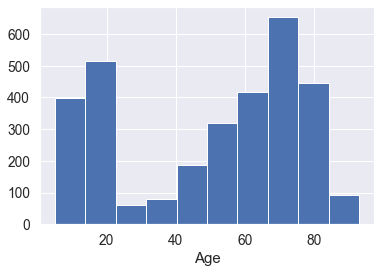

In [12]:
# Plot age distribution
def mean_std(x):
    print(f"{x.mean():.2f} ± {x.std():.2f} (min = {x.min():.2f}, median = {x.median()}, max = {x.max():.2f})")

grp_subj['age'].agg(mean_std)
grp_subj['age'].hist()
plt.xlabel("Age");

In [13]:
grp_subj['ahi'].agg(mean_std)

12.94 ± 16.35 (min = 0.00, median = 6.9491525424, max = 125.07)


In [14]:
grp_subj['bmi'].agg(mean_std)

27.42 ± 7.72 (min = 12.49, median = 26.307136155000002, max = 84.80)


In [15]:
100 * grp_subj['ethnicity'].value_counts(normalize=True).round(3)

caucasian    58.0
african      29.5
hispanic      7.0
other         5.5
Name: ethnicity, dtype: float64

### Create different combinations of predictors

In [16]:
cols_all = df.columns
cols_time = cols_all[cols_all.str.startswith('time_')].tolist()
# EEG also includes the time columns
cols_eeg = cols_all[cols_all.str.startswith('eeg_')].tolist() + cols_time  
cols_eog = cols_all[cols_all.str.startswith('eog_')].tolist()
cols_emg = cols_all[cols_all.str.startswith('emg_')].tolist()
cols_demo = ['age', 'male']

In [17]:
# Define predictors
X_all = {
    'eeg': df[cols_eeg],
    'eeg+demo': df[cols_eeg + cols_demo],
    'eeg+eog': df[cols_eeg + cols_eog],
    'eeg+eog+demo': df[cols_eeg + cols_eog + cols_demo],
    'eeg+eog+emg': df[cols_eeg + cols_eog + cols_emg],
    'eeg+eog+emg+demo': df[cols_eeg + cols_eog + cols_emg + cols_demo],
}

# Define target and groups
y = df['stage']
subjects = df.index.get_level_values(0).to_numpy()

In [18]:
# Export a full list of features
features = pd.Series(X_all['eeg+eog+emg+demo'].columns, name="Features")
features.to_csv("features.csv", index=False)

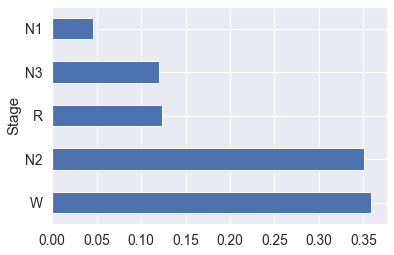

In [19]:
# % of each sleep stage
y.value_counts(normalize=True).plot.barh(xlabel="Stage", ylabel="Proportion");

In [20]:
# Define hyper-parameters
params = dict(
    boosting_type='gbdt',
    n_estimators=300,
    max_depth=7,
    num_leaves=70,
    colsample_bytree=0.8,
    importance_type='gain',
)

In [21]:
# from sklearn.utils.class_weight import compute_class_weight
# compute_class_weight('balanced', np.unique(y), y)

# Manually define class weight
# class_weight = None
# class_weight = "balanced"
class_weight = "custom"

if class_weight == "custom":
    # See output/classifiers/gridsearch_class_weights.xlsx
    params['class_weight'] = {'N1': 2, 'N2': 1, 'N3': 1.2, 'R': 1.2, 'W': 1}
else:
    params['class_weight'] = class_weight

****

## Fit the training set and export the trained classifier

In [22]:
# Parallel processing when building the trees.
params['n_jobs'] = 12

# Loop across combs of predictors
for name, X in tqdm(X_all.items()):
    
    # Fit
    clf = LGBMClassifier(**params)
    clf.fit(X, y)

    # Print the accuracy on the training dataset: shouldn't be too high..!
    print("%s (%i features) - training accuracy: %.3f" % 
        (name, X.shape[1], clf.score(X, y)))
    
    # Export trained classifier
    if params['class_weight'] is not None:
        fname = outdir + 'clf_%s_lgb_%s_%s.joblib' % \
        (name, params['boosting_type'], class_weight)
    else:
        fname = outdir + 'clf_%s_lgb_%s.joblib' % \
        (name, params['boosting_type'])
        
    # Export model
    joblib.dump(clf, fname, compress=True)
    
    # Also save directly to YASA
    # outdir_yasa = "/Users/raphael/GitHub/yasa/yasa/classifiers/"
    # fname_yasa = outdir_yasa + 'clf_%s_lgb.joblib' % name
    # joblib.dump(clf, fname_yasa, compress=True)
    
    # Features importance (full model only)
    if name == "eeg+eog+emg+demo":
        # Export LGBM feature importance
        df_imp = pd.Series(clf.feature_importances_, index=clf.feature_name_, name='Importance').round()
        df_imp.sort_values(ascending=False, inplace=True)
        df_imp.index.name = 'Features'
        df_imp.to_csv(fname[:-7] + ".csv")

        # Export SHAP feature importance
        # Calculate SHAP values on a random sample of 25% of the training set
        # We also limit the number of trees for speed
        explainer = shap.TreeExplainer(clf)
        shap_values = explainer.shap_values(X.sample(frac=0.25, random_state=42), tree_limit=100)
        # Sum across all stages and then average across all samples
        shap_sum = np.abs(shap_values).sum(axis=0).mean(axis=0)
        df_shap = pd.Series(shap_sum, index=X.columns.tolist(), name="Importance")
        df_shap.sort_values(ascending=False, inplace=True)
        df_shap.index.name = 'Features'
        df_shap.to_csv(fname[:-7] + "_shap.csv")

eeg (65 features) - training accuracy: 0.861
eeg+demo (67 features) - training accuracy: 0.867
eeg+eog (116 features) - training accuracy: 0.882
eeg+eog+demo (118 features) - training accuracy: 0.886
eeg+eog+emg (149 features) - training accuracy: 0.890
eeg+eog+emg+demo (151 features) - training accuracy: 0.893



In [23]:
# from matplotlib import colors
# cmap_stages = ['#99d7f1', '#009DDC', 'xkcd:twilight blue', 'xkcd:rich purple', 'xkcd:sunflower']
# cmap = colors.ListedColormap(np.array(cmap_stages)[class_inds])
# class_inds = np.argsort([-np.abs(shap_values[i]).mean() for i in range(len(shap_values))])
# shap.summary_plot(shap_values, X, plot_type='bar', max_display=15, color=cmap, 
#                   class_names=clf.classes_)